# BAT.jl Tutorial - Poisson Counting Experiment

*Note: This tutorial is written in the style of a cloze test. Parts that have to be filled out by you are marked `#=Please Fill=#`.*

For additional help, you can take a look at the [BAT.jl tutorial](https://bat.github.io/BAT.jl/stable/tutorial/) or the [BAT.jl documentation](https://bat.github.io/BAT.jl/stable/).

To get started, we first need to import some packages we will use in this tutorial:

In [1]:
using BAT
using Distributions 
using IntervalSets
using ValueShapes
using Plots
using ArraysOfArrays
using StatsBase 
using LinearAlgebra
using DensityInterface

┌ Warning: backend `GR` is not installed.
└ @ Plots C:\Users\Cornelius\.julia\packages\Plots\sxUvK\src\backends.jl:43


## Situation
In this tutorial, we want to determine the properties of a radioactive singal source in the presence of background from natural sources of radioactivity.  
We assume to have one signal source $S$ and only one source of background $B$. All measurements are taken for the same duration, so we do not distinguish between counts and rates.

## Part 1: A first background-only measurement
We start by using our detector without the signal source installed.  
This measurement yields a number of $k_B=10$ counts.  
Using this measurement we want to gain information about the event rate of the natural radioactive background.

### Task: 
We want to perform a Bayesian analysis to estimate the event rate of the natural background $\lambda_b$ using a Poisson model. 

We start by defining the corresponding log-likelihood function, using the function `logpdf()` and the type `Poisson` provided by the package [Distributions.jl](https://juliastats.github.io/Distributions.jl/latest/univariate/).

In [2]:
# Number of observed background events
kb = 10

likelihood_B = let k = kb
    logfuncdensity(function (params) # this function is part of the package DensityInterface.jl and is used to define the log-likelihood
        return logpdf(Poisson(params.λb), k) # poisson log-likelihood
    end)
end;

Next, we define the Prior distribution using the `distprod` function. We use a flat prior between 0 and 30:

In [3]:
prior_B = distprod(
    λb = 0..30., # This is a shorthand notation for Uniform(0, 30)
)

NamedTupleDist((λb = Uniform{Float64}(a=0.0, b=30.0),))

With the likelihood and prior, we can now define the `PosteriorDensity()` for the background-only scenario:

In [4]:
posterior_B = PosteriorMeasure(likelihood_B, prior_B)

PosteriorMeasure(objectid = 0xe9c3a8a6511edbf9, varshape = NamedTupleShape((:λb,)}(…))

We can now explore the posterior distribution, for example by first searching for the mode, i.e. the value of $\lambda_b$ with the highest probability density:

In [5]:
using Optim # we need to explicitly load the Optim package to use the bat_findmode function
mode_B = bat_findmode(posterior_B)

┌ Info: Setting new default BAT context BATContext{Float64}(Random123.Philox4x{UInt64, 10}(0x5bf71a8edbcaba63, 0x71f712c2ad85cd08, 0x0e1025687587bf93, 0xa93991ff100453f4, 0x7c6ad72ebfcaa621, 0xafda09a46c609d7d, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0x0000000000000000, 0), HeterogeneousComputing.CPUnit(), BAT._NoADSelected())
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\algotypes\bat_context.jl:121
┌ Warning: The option 'abstol' is not used for this algorithm.
└ @ BATOptimExt c:\Users\Cornelius\Documents\GitHub\BAT.jl\ext\BATOptimExt.jl:64


(result = (λb = 9.999889124458976,), result_trafo = [-0.4307374639317294], trafo = DistributionTransform(BAT.StandardMvNormal{Float64}(_dim=1), NamedTupleDist{(:λb,)}(…)), info = Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [-0.4345515278523844]
 * Maximizer: [-0.4307374639317294]
 * Maximum: -5.479759e+00
 * Iterations: 7
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 17, optargs = (algorithm = OptimAlg{NelderMead{Optim.AffineSimplexer, Optim.AdaptiveParameters}, PriorToGaussian, InitFromTarget}
  optalg: NelderMead{Optim.AffineSimplexer, Optim.AdaptiveParameters}
  trafo: PriorToGaussian PriorToGaussian()
  init: InitFromTarget InitFromTarget()
  maxiters: Int64 1000
  maxtime: Float64 NaN
  abstol: Float64 NaN
  reltol: Float64 0.0
  kwargs: NamedTuple{(), Tuple{}} NamedTuple()
, context = BATContext{Float64}(Random123.Philox4x{UInt64, 10}(0x5bf71a8edbcaba63, 0x71f712c2a

The value of the mode can be obtained as:

In [6]:
mode_B.result

(λb = 9.999889124458976,)

In a next step, we want to actually sample the posterior distribution to check other numerical properties and create plots.
For this, we first specify some settings for the sampling. We choose the `MetropolisHastings()` algorithm and use 4 Markov chains with 10^5 steps each:

In [7]:
algorithm = MCMCSampling(mcalg = MetropolisHastings(), nsteps = 10^5, nchains = 4)

MCMCSampling{MetropolisHastings{BAT.MvTDistProposal, RepetitionWeighting{Int64}, AdaptiveMHTuning}, PriorToGaussian, MCMCChainPoolInit, MCMCMultiCycleBurnin, BrooksGelmanConvergence, typeof(BAT.nop_func)}
  mcalg: MetropolisHastings{BAT.MvTDistProposal, RepetitionWeighting{Int64}, AdaptiveMHTuning}
  trafo: PriorToGaussian PriorToGaussian()
  nchains: Int64 4
  nsteps: Int64 100000
  init: MCMCChainPoolInit
  burnin: MCMCMultiCycleBurnin
  convergence: BrooksGelmanConvergence
  strict: Bool true
  store_burnin: Bool false
  nonzero_weights: Bool true
  callback: nop_func (function of type typeof(BAT.nop_func))


Using the function `bat_sample` we can then sample the posterior distribution:

In [8]:
samples_B = bat_sample(posterior_B, algorithm).result

┌ Info: MCMCChainPoolInit: trying to generate 4 viable MCMC chain(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\chain_pool_init.jl:69


┌ Info: Selected 4 MCMC chain(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\chain_pool_init.jl:195
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:38


┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:74
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:74


┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 4 tuned, 4 converged.
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:74
┌ Info: MCMC tuning of 4 chains successful after 3 cycle(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:80
┌ Info: Running post-tuning stabilization steps for 4 MCMC chain(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:91


DensitySampleVector, StructArray with 5 columns and 130572 rows:
      v                logd      weight  info                       aux
    ┌──────────────────────────────────────────────────────────────────────
 1  │ (λb = 11.9642,)  -5.65062  2       MCMCSampleID(3, 6, 0, 1)   nothing
 2  │ (λb = 8.87729,)  -5.54794  3       MCMCSampleID(3, 6, 2, 1)   nothing
 3  │ (λb = 11.1715,)  -5.54345  1       MCMCSampleID(3, 6, 5, 1)   nothing
 4  │ (λb = 11.0161,)  -5.52813  5       MCMCSampleID(3, 6, 6, 1)   nothing
 5  │ (λb = 3.9233,)   -8.75957  1       MCMCSampleID(3, 6, 11, 1)  nothing
 6  │ (λb = 6.49742,)  -6.28898  5       MCMCSampleID(3, 6, 12, 1)  nothing
 7  │ (λb = 11.0889,)  -5.53506  2       MCMCSampleID(3, 6, 17, 1)  nothing
 8  │ (λb = 10.7543,)  -5.50686  2       MCMCSampleID(3, 6, 19, 1)  nothing
 9  │ (λb = 19.8131,)  -8.45528  1       MCMCSampleID(3, 6, 21, 1)  nothing
 10 │ (λb = 21.7675,)  -9.4689   1       MCMCSampleID(3, 6, 22, 1)  nothing
 11 │ (λb = 6.83599,)  -6.1

Let us now look at some numerical properties of the posterior distribution obtained from the samples:

In [9]:
bat_report(samples_B)

### Sampling result

  * Total number of samples: 130572
  * Total weight of samples: 399995
  * Effective sample size: between 55401 and 55401

#### Marginals

| Parameter | Mean    | Std. dev. | Gobal mode | Marg. mode |  Cred. interval  | Histogram                                                  |
|:--------- |:------- |:--------- |:---------- |:---------- |:----------------:|:---------------------------------------------------------- |
| λb        | 11.0078 | 3.31898   | 10.0       | 9.9        | 7.33313..13.7032 | ⠀⠀⠀⠀1.94[⠀⠀⠀⠀▁▂▃▅▆▇████▇▆▅▄▃▃▂▁▁▁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀[29.3⠀⠀⠀⠀ |


The individual numerical values shown above can be also obtained using the functions `mean`, `mode`, `std`, ... on the samples object, e.g.:

In [10]:
mean(samples_B).λb

11.007847781262038

Let us now also take a look at the resulting disribution for the background rate using the `plot()` function:

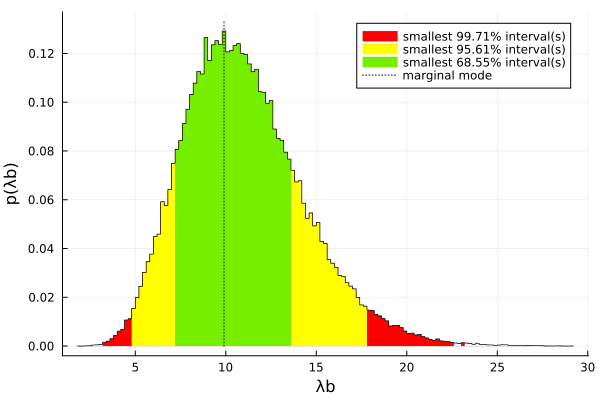

In [11]:
plot(samples_B, :λb)

We can also plot the prior distribution on top of the posterior to visualize the knowledge update we gained by analyzing the data:

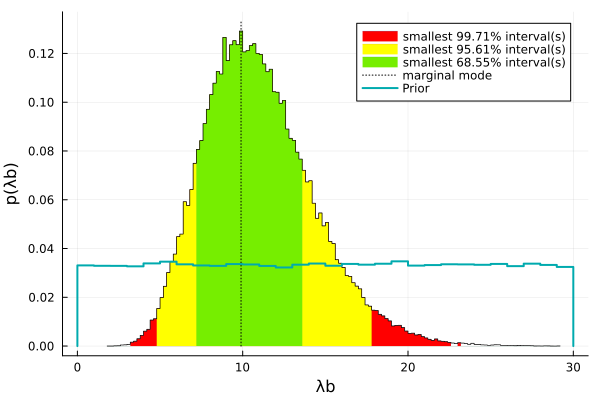

In [12]:
plot(samples_B, :λb)

samples_prior_B = rand(prior_B, 100_000).λb
plot!(samples_prior_B, st=:stephist, normalize=true, lw=2, label="Prior")

### Additional Tasks:
Play around with the settings of the sampling algorithm. What happens if you, e.g.
* change the number of chains ?
* change the number of steps per chain ?
* pick a different sampling algorithm from the [List of algorithms](https://bat.github.io/BAT.jl/stable/list_of_algorithms/#Sampling-algorithms) ?


## Part 2: Second background-only measurement
A second measurement of the natural background is perfomed (for the same duration) and yields a number of $k_B=8$ counts.  
Therefore, we want to update our estimation of the background rate using this new knowledge together with the pervious results.
### Task:
We want to perform an analysis of the new measurement similar to the first one.   
We want to use the posterior distribution of the previous background measurement as a prior for this analysis.  
For this, we need to convert our previous samples into a [StatsBase histogram](http://juliastats.github.io/StatsBase.jl/latest/empirical/#Histograms-1).

We build a `StatsBase` histogram containing the previous posterior distribution:

In [13]:
samples_flat = samples_B.v.λb
weights = FrequencyWeights(samples_B.weight)

posterior_hist_B1 = fit(Histogram, samples_flat, weights, nbins = 400)

Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  1.9:0.1:29.3
weights: [1, 0, 1, 2, 5, 4, 6, 17, 18, 18  …  4, 2, 3, 1, 0, 0, 0, 1, 2, 4]
closed: left
isdensity: false

This histogram can now be used as a prior by converting it into a univariate binned distribution (`UvBinnedDist`) using the package `EmpiricalDistributions.jl`:

In [14]:
using EmpiricalDistributions

prior_B2 = distprod(
    λb = UvBinnedDist(posterior_hist_B1)
)

NamedTupleDist((λb = UvBinnedDist{Float64, Float64, Vector{Float64}, Vector{Float64}}(
_edge: [1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8  …  28.4, 28.5, 28.6, 28.7, 28.8, 28.9, 29.0, 29.1, 29.2, 29.3]
_edge_cdf: [0.0, 2.500031250390632e-6, 2.500031250390632e-6, 5.000062500781264e-6, 1.0000125001562506e-5, 2.2500281253515664e-5, 3.250040625507819e-5, 4.750059375742198e-5, 9.000112501406272e-5, 0.0001350016875210939  …  0.9999674995937449, 0.9999724996562457, 0.9999799997499969, 0.9999824997812472, 0.9999824997812472, 0.9999824997812472, 0.9999824997812472, 0.9999849998124977, 0.9999899998749984, 1.0]
_bin_pdf: [2.50003125039063e-5, 0.0, 2.50003125039063e-5, 5.00006250078126e-5, 0.0001250015625195315, 0.0001000012500156252, 0.0001500018750234378, 0.00042500531256640706, 0.0004500056250703134, 0.0004500056250703134  …  0.0001000012500156252, 5.00006250078126e-5, 7.50009375117189e-5, 2.50003125039063e-5, 0.0, 0.0, 0.0, 2.50003125039063e-5, 5.00006250078126e-5, 0.0001000012500156252]

Now we define the new log-likelihood function and build the new posterior distribution:

In [15]:
kb2 = 8

likelihood_B2 = let k = kb2
    logfuncdensity(function (params)
        return logpdf(Poisson(params.λb), k) #=FILLME=#
    end)
end;

In [16]:
posterior_B2 = PosteriorMeasure(likelihood_B2, prior_B2) #=FILLME=#

PosteriorMeasure(objectid = 0xf251f975798115af, varshape = NamedTupleShape((:λb,)}(…))

And generate samples:  
(Note: By default, BAT.jl internally performes a phase space transformation according to the prior distribution in order to make the sampling more efficient. As this is currently not supported for priors containing `UvBinnedDist`s, we need to explicitly disable this transformation using ` trafo=DoNotTransform()`.)

In [17]:
samples_B2 = bat_sample(posterior_B2, MCMCSampling(mcalg = MetropolisHastings(), nsteps = 10^5, nchains = 4, trafo=DoNotTransform())).result #=FillMe=#

┌ Info: MCMCChainPoolInit: trying to generate 4 viable MCMC chain(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\chain_pool_init.jl:69


┌ Info: Selected 4 MCMC chain(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\chain_pool_init.jl:195
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:38
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 4 tuned, 4 converged.
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:74
┌ Info: MCMC tuning of 4 chains successful after 1 cycle(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:80
┌ Info: Running post-tuning stabilization steps for 4 MCMC chain(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:91


DensitySampleVector, StructArray with 5 columns and 130548 rows:
      v                logd      weight  info                        aux
    ┌───────────────────────────────────────────────────────────────────────
 1  │ (λb = 10.6693,)  -4.3885   2       MCMCSampleID(17, 4, 0, 1)   nothing
 2  │ (λb = 10.0649,)  -4.31089  3       MCMCSampleID(17, 4, 2, 1)   nothing
 3  │ (λb = 12.3461,)  -5.12138  4       MCMCSampleID(17, 4, 5, 1)   nothing
 4  │ (λb = 8.4912,)   -4.16414  8       MCMCSampleID(17, 4, 9, 1)   nothing
 5  │ (λb = 9.44548,)  -4.15567  4       MCMCSampleID(17, 4, 17, 1)  nothing
 6  │ (λb = 7.98595,)  -4.30186  3       MCMCSampleID(17, 4, 21, 1)  nothing
 7  │ (λb = 11.2751,)  -4.64665  1       MCMCSampleID(17, 4, 24, 1)  nothing
 8  │ (λb = 8.18874,)  -4.19295  1       MCMCSampleID(17, 4, 25, 1)  nothing
 9  │ (λb = 10.5406,)  -4.40787  1       MCMCSampleID(17, 4, 26, 1)  nothing
 10 │ (λb = 10.7748,)  -4.48426  2       MCMCSampleID(17, 4, 27, 1)  nothing
 11 │ (λb = 10.

Let us now visualize both the prior (i.e. the posterior of the first analysis) and the updated posterior:

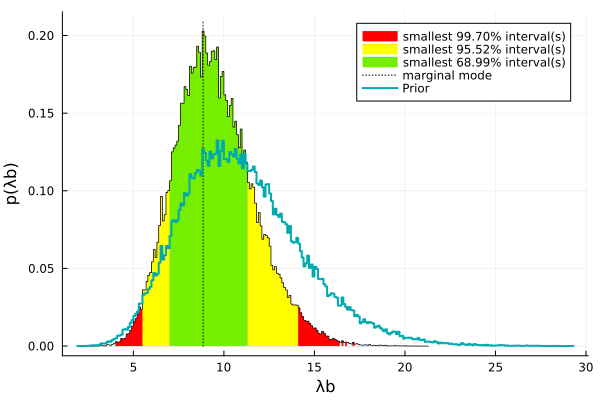

In [18]:
plot(samples_B2, :λb)
plot!(rand(prior_B2, 1_000_000).λb, st=:stephist, lw=2, normalize=true, label="Prior")

In [19]:
bat_report(samples_B2) #=FILLME=#

### Sampling result

  * Total number of samples: 130548
  * Total weight of samples: 399983
  * Effective sample size: between 56608 and 56608

#### Marginals

| Parameter | Mean    | Std. dev. | Gobal mode | Marg. mode |  Cred. interval  | Histogram                                                  |
|:--------- |:------- |:--------- |:---------- |:---------- |:----------------:|:---------------------------------------------------------- |
| λb        | 9.49701 | 2.17065   | 8.80003    | 8.9        | 7.06171..11.2948 | ⠀⠀⠀⠀2.61[⠀⠀⠀⠀⠀⠀▁▂▃▅▆▇████▇▆▅▄▃▂▂▁▁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀[21.4⠀⠀⠀⠀ |


## Part 3: Signal + Background Measurement
Now we include the radioactive source into the experimental setup. We repeat the measurement and now observe $k_{S+B}=12$ counts.  
With this measurement and our prior knowledge about the background we are now able to estimate the signal rate $\lambda_s$.
### Task
Perform a third analysis using a poisson model with the combined singal + background rate.  
Use the known information about the background from the previous tasks as a prior for the backround and choose a suitable prior for the signal.

Define the likelihood for the signal + background model:

In [20]:
# Number of observed events
kSB = 12

likelihood_SB = let k = kSB
    logfuncdensity(function (params)
        return logpdf(Poisson(params.λb + params.λs), k)  # poisson log-likelihood for b+s #=FILLME=#
    end)
end;

Define the prior for both the signal and backgound parameters.
Choose a flat prior in the range (0, 30) for the signal rate.  
Remember to use the knowledge from the previous tasks for the prior of the background rate.  


In [21]:
posterior_hist_B2 = fit(Histogram, samples_B2.v.λb, FrequencyWeights(samples_B2.weight), nbins = 400)

prior_SB = NamedTupleDist( #=FILLME=#
    λb = UvBinnedDist(posterior_hist_B2),
    λs = 0..30
)

NamedTupleDist((λb = UvBinnedDist{Float64, Float64, Vector{Float64}, Vector{Float64}}(
_edge: [2.6, 2.65, 2.7, 2.75, 2.8, 2.85, 2.9, 2.95, 3.0, 3.05  …  20.95, 21.0, 21.049999999999997, 21.099999999999998, 21.15, 21.2, 21.25, 21.299999999999997, 21.349999999999998, 21.4]
_edge_cdf: [0.0, 7.500318763547423e-6, 7.500318763547423e-6, 7.500318763547423e-6, 7.500318763547423e-6, 1.5000637527094913e-5, 1.5000637527094913e-5, 1.5000637527094913e-5, 2.000085003612653e-5, 2.5001062545158146e-5  …  0.9999974998937458, 0.9999974998937458, 0.9999974998937458, 0.9999974998937458, 0.9999974998937458, 0.9999974998937458, 0.9999974998937458, 0.9999974998937458, 0.9999974998937458, 1.0]
_bin_pdf: [0.000150006375270949, 0.0, 0.0, 0.0, 0.000150006375270949, 0.0, 0.0, 0.00010000425018063267, 0.00010000425018063267, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.000212509031633e-5]
_bin_probmass: [7.500318763547423e-6, 0.0, 0.0, 0.0, 7.50031876354749e-6, 0.0, 0.0, 5.000212509031616e-6, 5.0002125090

Define the posterior for the signal + backround analysis:

In [22]:
posterior_SB = PosteriorMeasure(likelihood_SB, prior_SB); #=FILLME=#

Generate samples for the signal + background model:  
(Note: Again use `trafo=DoNotTransform()`.)

In [23]:
samples_SB = bat_sample(posterior_SB, MCMCSampling(mcalg = MetropolisHastings(), nsteps = 10^5, nchains = 4, trafo=DoNotTransform())).result #=FillMe=#

┌ Info: MCMCChainPoolInit: trying to generate 4 viable MCMC chain(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\chain_pool_init.jl:69


┌ Info: Selected 4 MCMC chain(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\chain_pool_init.jl:195
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:38
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:74
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 4 tuned, 4 converged.
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:74
┌ Info: MCMC tuning of 4 chains successful after 2 cycle(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:80
┌ Info: Running post-tuning stabilization steps for 4 MCMC chain(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:91


DensitySampleVector, StructArray with 5 columns and 112383 rows:
      v                       logd      weight  info                    aux
    ┌──────────────────────────────────────────────────────────────────────────
 1  │ (λb = 9.59712, λs = 7…  -8.23097  4       MCMCSampleID(20, 5, 0…  nothing
 2  │ (λb = 8.70696, λs = 1…  -7.47393  2       MCMCSampleID(20, 5, 4…  nothing
 3  │ (λb = 11.8658, λs = 1…  -8.15457  10      MCMCSampleID(20, 5, 6…  nothing
 4  │ (λb = 8.49676, λs = 3…  -7.26768  5       MCMCSampleID(20, 5, 1…  nothing
 5  │ (λb = 9.77449, λs = 2…  -7.44204  4       MCMCSampleID(20, 5, 2…  nothing
 6  │ (λb = 10.1644, λs = 4…  -7.63727  1       MCMCSampleID(20, 5, 2…  nothing
 7  │ (λb = 9.73474, λs = 2…  -7.37184  2       MCMCSampleID(20, 5, 2…  nothing
 8  │ (λb = 10.2516, λs = 0…  -7.63542  3       MCMCSampleID(20, 5, 2…  nothing
 9  │ (λb = 10.0421, λs = 8…  -8.69234  2       MCMCSampleID(20, 5, 3…  nothing
 10 │ (λb = 9.45539, λs = 9…  -8.54717  2       MCMCSampleI

To visualize an overview of the results for both prameters simply use `plot(samples_SB)`:    
You can also indicate the global mode adding the keyword `globalmode=true`.

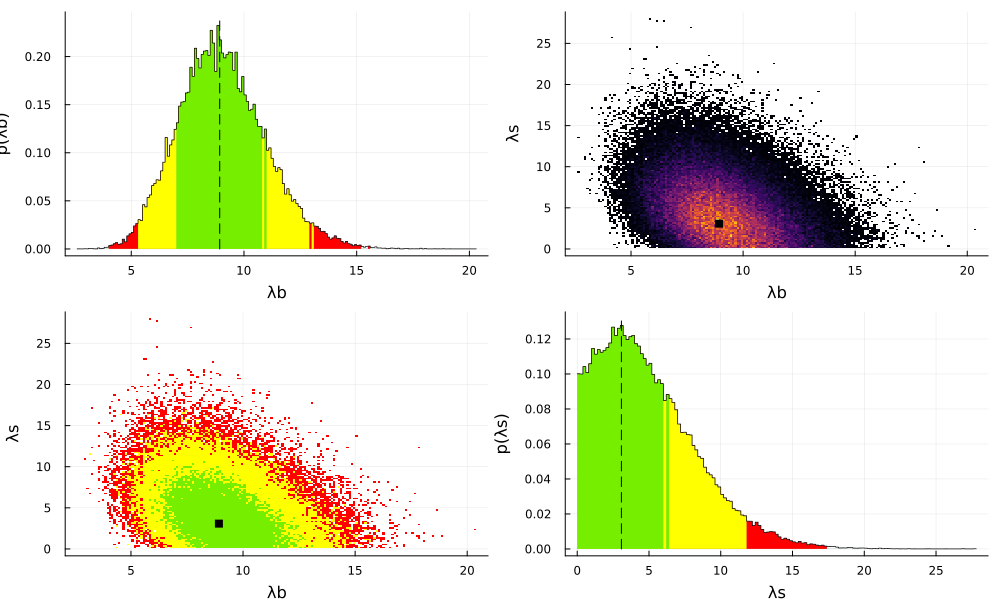

In [24]:
plot(samples_SB, globalmode=true) #=FILLME=#

Alsoe, print some statistics of the samples:

In [25]:
bat_report(samples_SB)

### Sampling result

  * Total number of samples: 112383
  * Total weight of samples: 399994
  * Effective sample size: between 25403 and 29171

#### Marginals

| Parameter | Mean    | Std. dev. | Gobal mode | Marg. mode |   Cred. interval    | Histogram                                                  |
|:--------- |:------- |:--------- |:---------- |:---------- |:-------------------:|:---------------------------------------------------------- |
| λb        | 9.03267 | 1.92805   | 8.92392    | 8.75       |   7.0352..10.8509   | ⠀⠀⠀⠀⠀2.6[⠀⠀⠀⠀⠀⠀▁▂▃▄▆▇████▇▆▅▄▃▂▁▁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀[20.3⠀⠀⠀⠀ |
| λs        | 4.9358  | 3.41648   | 3.07838    | 2.75       | 6.43629e-5..6.15855 | 6.44e-05[▇▇█████▇▆▆▄▄▃▂▂▁▁▁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀[27.9⠀⠀⠀⠀ |


## Part 3 b) - Combined analyses
Let us now perform the same analysis but this time using all three measurments (first background measuerment, second background measurement, and the signal + backround measurements) at the same time instead of inserting them sequentially.

In [26]:
prior_SB_2 = NamedTupleDist( #=FILLME=#
    λb = 0..30,
    λs = 0..30
)


likelihood_SB_2 = let k = [10, 8, 12]
    logfuncdensity(function (params)
        b1 = logpdf(Poisson(params.λb), k[1])
        b2 = logpdf(Poisson(params.λb), k[2])
        sb = logpdf(Poisson(params.λb + params.λs), k[3])
        return b1 + b2 + sb  # poisson log-likelihood for b+s #=FILLME=#
    end)
end;


posterior_SB_2 = PosteriorMeasure(likelihood_SB_2, prior_SB_2); #=FILLME=#

In [27]:
samples_SB_2 = bat_sample(posterior_SB_2, MCMCSampling(mcalg = MetropolisHastings(), nsteps = 10^5, nchains = 4)).result #=FillMe=#
bat_report(samples_SB_2)

┌ Info: MCMCChainPoolInit: trying to generate 4 viable MCMC chain(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\chain_pool_init.jl:69


┌ Info: Selected 4 MCMC chain(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\chain_pool_init.jl:195
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:38


┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:74
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 4 tuned, 4 converged.
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:74
┌ Info: MCMC tuning of 4 chains successful after 2 cycle(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:80
┌ Info: Running post-tuning stabilization steps for 4 MCMC chain(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:91


### Sampling result

  * Total number of samples: 114264
  * Total weight of samples: 399994
  * Effective sample size: between 31044 and 34468

#### Marginals

| Parameter | Mean    | Std. dev. | Gobal mode | Marg. mode |    Cred. interval    | Histogram                                                  |
|:--------- |:------- |:--------- |:---------- |:---------- |:--------------------:|:---------------------------------------------------------- |
| λb        | 9.01994 | 1.92826   | 8.99196    | 8.75       |   6.82017..10.644    | ⠀⠀⠀⠀2.28[⠀⠀⠀⠀⠀⠀▁▂▄▅▇████▇▆▄▃▂▁▁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀[22⠀⠀⠀⠀⠀⠀ |
| λs        | 4.91395 | 3.37379   | 3.02495    | 2.75       | 0.000182889..6.12265 | 0.000183[▇▇█████▇▆▅▅▄▃▂▂▁▁▁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀[27.6⠀⠀⠀⠀ |


## 4. Error propagation

Finally, we want to caluclate the cross section of the signal process.  
The rate of measured events in the detector of a couting experiment can be written as 

$\frac{\mathrm d N}{\mathrm d t} = \epsilon \cdot σ \cdot L$ ,

with the Luminosity $L$ and the efficiency of the detector $\epsilon$.   
The signal cross section is therefore given as:
#### $σ_S = \frac{λ_s}{\epsilon \cdot L}$.  
For this experiment we assume a luminosity of $L = 1.1$  (neglecting units).

As a final result we want to obtain either a measurement or an upper limit on the signal cross section.

### Task 4 a) Known efficiency with gaussian uncertainty
The detector efficiency has been measured to be $\epsilon = 0.1 \pm 0.02$, assuming the uncertainties to follow a normal distribution.

We want to calculate the signal cross section $σ_S$ using the equation above.

Use the [Distrtibutions.jl](https://juliastats.github.io/Distributions.jl/latest/univariate/) package and `rand()` to obain samples for $\epsilon$.  
In order to obtain the same number of unweigthed samples of $\lambda_S$ the function `bat_sample(samples, RandResampling(nsamples=nsamples))` can be used for resampling the posterior samples.

The function `broadcast()` or the `.`operator (e.g. `a .+ b`) might be useful for element-wise operation when handeling the samples.  

Define the luminosity and the efficiency:

In [28]:
nsamples = 100_000

L = 1.1 #=FILLME=#
ϵ = rand(Normal(0.1, 0.02), nsamples) #=FILLME=#

100000-element Vector{Float64}:
 0.13282190408699845
 0.11808465887870102
 0.11762659636327764
 0.06545437506926875
 0.08382722053999714
 0.10851992162120556
 0.10729311909404118
 0.08747200684462475
 0.1028847380579509
 0.0749159811671926
 ⋮
 0.1241417933250133
 0.09846913872651133
 0.12224912651522869
 0.1398670917338085
 0.07174306433945711
 0.09702174188123265
 0.1122659854197315
 0.11085724936661726
 0.09287033949008291

Let us quickly plot the efficiency.  Use a [StatsBase histogram](http://juliastats.github.io/StatsBase.jl/latest/empirical/#Histograms-1) to visualize the distribution.  
(Hint: The plot recipes can also be used for the `StatsBase` histograms) 

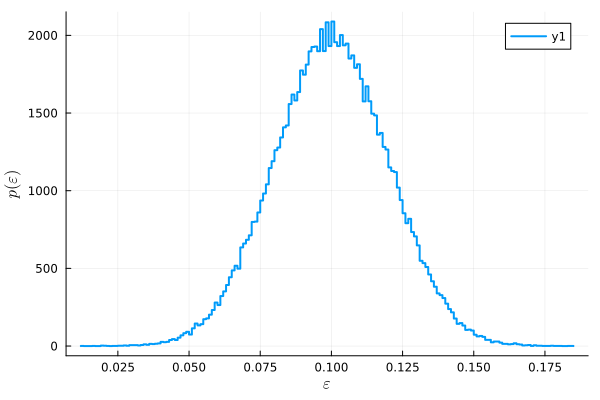

In [29]:
hist_ϵ = fit(Histogram, ϵ, nbins=200) 

plot(hist_ϵ, st=:steps, normalize=true, lw=2, xlabel="\$\\epsilon\$", ylabel="\$p(\\epsilon)\$")


Now, let's get unweighted samples for the signal rate and calculate the cross section distribution:

In [30]:
resampled_SB = bat_sample(samples_SB, RandResampling(nsamples=nsamples)).result
λs = resampled_SB.v.λs

100000-element view(::ElasticArrays.ElasticMatrix{Float64, Vector{Float64}}, 2, :) with eltype Float64:
  6.7938414041844
  9.071264784620663
  0.930850374472632
  6.096617318040666
  0.553854591340806
  4.86299499167294
  9.902599878891742
  8.09293284551008
  5.426040318404354
  0.7473038711178774
  ⋮
 10.173456847539804
  9.901073492055092
  2.2596829810166987
  7.521054023080962
  2.140540135421354
  7.950169276775673
  3.2373040071513413
  0.8046082283365417
  1.1800157129692814

In [31]:
σS = (λs)./(ϵ*L);

Plot the distribution of the signal cross section. (Hint: use again a histogram)  

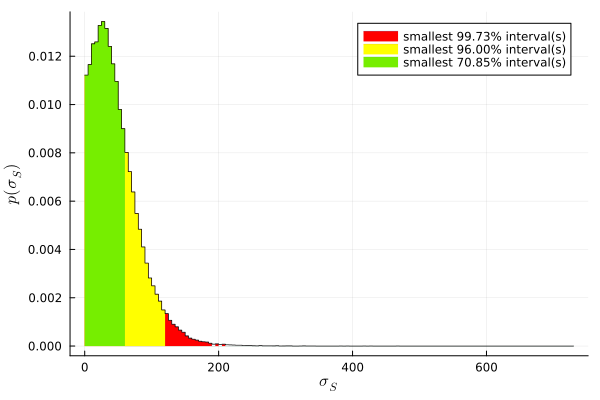

In [32]:
hist_σS = fit(Histogram, σS, nbins=300)
bat_hist = BAT.MarginalDist(UvBinnedDist(hist_σS))
plot(bat_hist, st=:smallest_intervals, xlabel="\$\\sigma_S\$", ylabel="\$p(\\sigma_S)\$")

Did we measure the signal process? Or can we only set an upper limit? 

### Task 4 b) Binomial analysis of calibration measurement to determine efficiency 
We now want to perform the same analysis as in task 4 a) but for the case that the detector efficiency $\epsilon$ is not yet known.   

 Instead, $\epsilon$ is to be determined using a calibration measurement with a source for which the signal rate is known. Then it is possible to calculate the efficiency from the expected number of counts and the number of counts actually measured with the detector.   


For our example, the number of expected events is assumed to be $N_\text{expected} = 200$.  
The detector measures only $N_\text{measured} = 21$ events.  

Task: Implement a binomial model using the `Binomial(n,p)` function of the [Distrtibutions.jl](https://juliastats.github.io/Distributions.jl/latest/univariate/) package and determine the distribution of the detector efficiency.  
Afterwards, repeat the steps from 4 a) using the obtained distribution of the efficiency to calculate the signal cross section .

Define the binomial likelihood:

In [33]:
n_expected = 200
n_measured = 21

likelihood_binomial = let n = n_expected, k = n_measured
    logfuncdensity(function (params)
        return logpdf(Binomial(n, params.ε), k) #=FILLME=#
    end)
end

LogFuncDensity(var"#19#20"{Int64, Int64}(200, 21))

Define the prior (flat) for the efficiency and define the posterior:

In [34]:
prior_binomial = distprod(
    ε = 0..1,
)#=FILLME=#

posterior_binomial = PosteriorMeasure(likelihood_binomial, prior_binomial)#=FILLME=#

PosteriorMeasure(objectid = 0x100fc05b84ca97b8, varshape = NamedTupleShape((:ε,)}(…))

Generate the samples:

In [35]:
samples_binomial = bat_sample(posterior_binomial, MCMCSampling(mcalg = MetropolisHastings(), nsteps = 10^5, nchains = 4)).result #=FillMe=#

┌ Info: MCMCChainPoolInit: trying to generate 4 viable MCMC chain(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\chain_pool_init.jl:69


┌ Info: Selected 4 MCMC chain(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\chain_pool_init.jl:195
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:38


┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:74
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:74
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 4 tuned, 4 converged.
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:74
┌ Info: MCMC tuning of 4 chains successful after 3 cycle(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:80
┌ Info: Running post-tuning stabilization steps for 4 MCMC chain(s).
└ @ BAT c:\Users\Cornelius\Documents\GitHub\BAT.jl\src\samplers\mcmc\multi_cycle_burnin.jl:91


DensitySampleVector, StructArray with 5 columns and 134319 rows:
      v                 logd      weight  info                        aux
    ┌────────────────────────────────────────────────────────────────────────
 1  │ (ε = 0.0834266,)  -2.95611  8       MCMCSampleID(11, 6, 0, 1)   nothing
 2  │ (ε = 0.0875786,)  -2.74884  5       MCMCSampleID(11, 6, 8, 1)   nothing
 3  │ (ε = 0.102562,)   -2.39617  1       MCMCSampleID(11, 6, 13, 1)  nothing
 4  │ (ε = 0.113413,)   -2.46172  2       MCMCSampleID(11, 6, 14, 1)  nothing
 5  │ (ε = 0.0826374,)  -3.00165  2       MCMCSampleID(11, 6, 16, 1)  nothing
 6  │ (ε = 0.092973,)   -2.55504  1       MCMCSampleID(11, 6, 18, 1)  nothing
 7  │ (ε = 0.0943725,)  -2.51769  3       MCMCSampleID(11, 6, 19, 1)  nothing
 8  │ (ε = 0.108931,)   -2.40584  1       MCMCSampleID(11, 6, 22, 1)  nothing
 9  │ (ε = 0.143886,)   -3.72468  1       MCMCSampleID(11, 6, 23, 1)  nothing
 10 │ (ε = 0.105394,)   -2.38992  6       MCMCSampleID(11, 6, 24, 1)  nothing
 11

Plot the distribution of the efficiency:  
(What do you observe when comparing to the efficiency used in 4 a) ?)

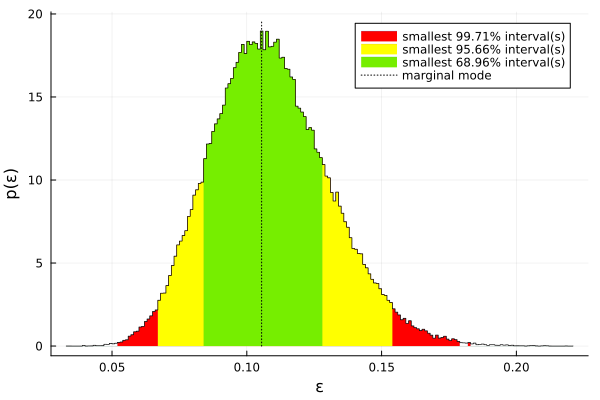

In [36]:
plot(samples_binomial, :ε#=FILLME=#)

Print some statistics of the samples:

In [37]:
bat_report(samples_binomial)

### Sampling result

  * Total number of samples: 134319
  * Total weight of samples: 399997
  * Effective sample size: between 60769 and 60769

#### Marginals

| Parameter | Mean     | Std. dev. | Gobal mode | Marg. mode |   Cred. interval   | Histogram                                                  |
|:--------- |:-------- |:--------- |:---------- |:---------- |:------------------:|:---------------------------------------------------------- |
| ε         | 0.108752 | 0.0218682 | 0.105      | 0.105      | 0.0837996..0.12723 | ⠀⠀⠀0.033[⠀⠀⠀⠀⠀⠀⠀▁▂▃▄▆▇█████▆▆▄▄▃▂▁▁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀[0.222⠀⠀⠀ |


Calculate the cross section by sampling the same number of events from the efficiency and from the signal samples:  
(Hint: proceed like in 4 a) for the samples of $\lambda$_SB )

In [38]:
nsamples = 100_000
resampled_SB = bat_sample(samples_SB, RandResampling(nsamples=nsamples)).result
resampled_binomial = bat_sample(samples_binomial, RandResampling(nsamples=nsamples)).result

@assert length(resampled_SB) == length(resampled_binomial)

In [39]:
λ_SB = resampled_SB.v.λs
ϵ   = resampled_binomial.v.ε
σS = (λ_SB)./(ϵ*L)

100000-element Vector{Float64}:
 16.655507835509617
 47.85135003881756
 26.58733531183239
 57.348707497758824
  0.6410274863904479
 22.770756888293494
 27.706111844189422
 28.39549304040568
 16.804315590412234
 21.047097338082477
  ⋮
 31.67638735612204
 89.91956408145866
 26.034727032546098
 32.812211521654355
 41.83866379059336
 23.25023660639879
 19.10304142902599
 39.13626961745247
 21.344255691758065

Use a `StatsBase`histogram to visualize the cross section distribution.  
From the plot, determine the 95% upper limit on the cross section.

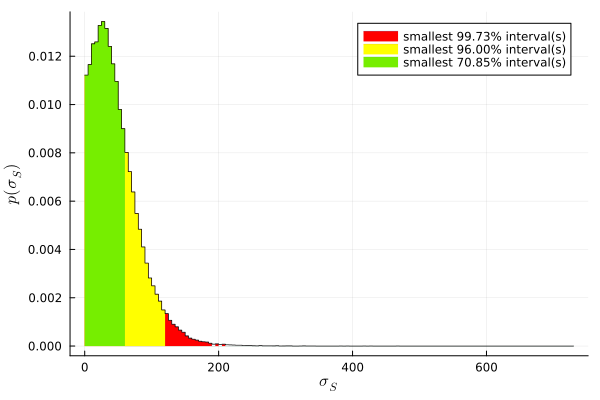

In [40]:
hist_σ = fit(Histogram, σS, nbins=200)
bat_hist = BAT.MarginalDist(UvBinnedDist(hist_σS))
plot(bat_hist, st=:smallest_intervals, xlabel="\$\\sigma_S\$", ylabel="\$p(\\sigma_S)\$")

Compare the distribution of the signal cross section to the distribution from 4 a).